# Second Goal (Visualisation) 
<b>Goal </b>: Know how to visualise data by using maps. <p>
<b>Present</b>: I know how to make different simple graphs by using matplotlib.<p>
<b>Measure</b>: At the end of the course, I want to be able to combine non-spatial data with spatial data to produce a cartogram in Python.

Within this jupyter notebook, I examine data from the Convention on International Trade in Endangered Species of Wild Fauna and Flora (CITES) for the years 2019 - 2021. This dataset covers trade of endangered species around the globe. Three research questions are answered within this notebook.



1. Which countries are major importers of endangered species? 
2. Which countries are major exporters of endangered species?
3. What is main purpose of the species imported/exported species in the highest importer/exporter country?

The objective is to answer these research question through the use of meaningful visualisations. RQs one and two are answered by using cartograms, RQ three through barplots. <p>
The data was obtained from the CITES trade database: https://trade.cites.org/en/cites_trade/#


In [1]:
#Importer relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import pycountry as pyc

#if needed
#$ pip install pycountry

In [2]:
#Import pre-downloaded data
df = pd.read_csv("https://raw.githubusercontent.com/zyankarli/Data-for-individual-portfolio/main/CITES_19-21.csv", sep=',')
#Check dataframe
df.head()

,Year,App.,Taxon,Class,Order,Family,Genus,Importer,Exporter,Origin,Importer reported quantity,Exporter reported quantity,Term,Unit,Purpose,Source
0,2019,I,Aquila adalberti,Aves,Falconiformes,Accipitridae,Aquila,CH,FR,MO,NaN,1.0,bodies,NaN,P,O
1,2019,I,Aquila heliaca,Aves,Falconiformes,Accipitridae,Aquila,CH,AT,UA,NaN,1.0,bodies,NaN,P,O
2,2019,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,IS,DK,XX,NaN,252.0,specimens,NaN,S,O
3,2019,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,IS,DK,XX,NaN,30.0,specimens,NaN,S,W
4,2019,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,XV,FR,DE,NaN,1.0,live,NaN,Q,C


Unfortunately the dataframe is hard to interpret because appreviations are not always clear. So let's translate them! <p>
Source for translations: https://trade.cites.org/cites_trade_guidelines/en-CITES_Trade_Database_Guide.pdf

In [3]:
#Create dicts to translate confusing appreviations
#Dict to translate Source
source_code = {
    'W': 'Wild',
    'X': 'Marine Environment', 
    'R': 'Ranched Animal', 
    'D': 'Captive-bred', 
    'A': 'Artif. prop. Plant', 
    'C': 'Bred in Captivity', 
    'F': 'Born in Captivity', 
    'U': 'Unknown', 
    'I': 'Confiscated', 
    'O': 'Pre-Convention'
}
#Dict to translate Purpose
purpose_code = {
    'B': 'Breeding in captivity', 
    'E':'Educational',
    'G': 'Botanical garden',
    'H': 'Hunting trophy',
    'L': 'Law enforcement',
    'M': 'Medical',
    'N': 'Reintroduction',
    'P': 'Personal',
    'Q': 'Circus',
    'S': 'Scientific',
    'T': 'Commercial',
    'Z': 'Zoo'
}

#Dict to translate Importer, Exporter & Origin
#Add non-ISO codes
full_country_name = {
    'XA': 'French Antilles',
    'XC': 'Caribbean',
    'XE': 'Europe',
    'XF': 'Africa',
    'XM': 'South America',
    'XS': 'Asia',
    'XV': 'Various',
    'XX': 'Unknown'
}
#Add country codes from pycountry library
for country in pyc.countries:
    full_country_name[country.alpha_2]=country.name

#Check whether it worked
print(len(full_country_name))
full_country_name['FR']

257


'France'

In [4]:
#Translate appreviations by using dicts
df['Source'].replace(source_code, inplace = True)
df['Purpose'].replace(purpose_code, inplace = True)
df['Importer'].replace(full_country_name, inplace = True)
df['Exporter'].replace(full_country_name, inplace = True)
df['Origin'].replace(full_country_name, inplace = True )
#Check whether it worked
df.head()

,Year,App.,Taxon,Class,Order,Family,Genus,Importer,Exporter,Origin,Importer reported quantity,Exporter reported quantity,Term,Unit,Purpose,Source
0,2019,I,Aquila adalberti,Aves,Falconiformes,Accipitridae,Aquila,Switzerland,France,Macao,NaN,1.0,bodies,NaN,Personal,Pre-Convention
1,2019,I,Aquila heliaca,Aves,Falconiformes,Accipitridae,Aquila,Switzerland,Austria,Ukraine,NaN,1.0,bodies,NaN,Personal,Pre-Convention
2,2019,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,Iceland,Denmark,Unknown,NaN,252.0,specimens,NaN,Scientific,Pre-Convention
3,2019,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,Iceland,Denmark,Unknown,NaN,30.0,specimens,NaN,Scientific,Wild
4,2019,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,Various,France,Germany,NaN,1.0,live,NaN,Circus,Bred in Captivity


In the following, I extract information about importer and exporter nations and aggregate them in a dataframe in order to facilitate the plotting procedure. Because the map used for creating the cartograms - a map provided by geopandas called *natural earth lowres* - uses ISO alpha 3 labels of countries, these labels are added and set to be the index of the importer and exporter dataframes.

In [5]:
#Get list of absolute frequency of Importers and Exporters
importer = pd.DataFrame(df['Importer'].value_counts()).reset_index()
importer.rename(columns={'index': 'Country','Importer': 'Number of imported Species'}, inplace=True)
exporter = pd.DataFrame(df['Exporter'].value_counts()).reset_index()
exporter.rename(columns={'index': 'Country','Exporter': 'Number of exported Species'}, inplace=True)

#For plotting, add ISO alpha_3 labels
    #Create dict with alpha_3 labels 
iso_a3_dict = {}
for country in pyc.countries:
    iso_a3_dict[country.name]=country.alpha_3
    #Add alpha 3 label to dataframes 
importer['iso_a3'] = importer['Country'].replace(iso_a3_dict)
exporter['iso_a3'] = exporter['Country'].replace(iso_a3_dict)
    #Set indices for merge
importer.set_index('iso_a3', inplace = True)
exporter.set_index('iso_a3', inplace = True)

print(importer.head(10))
print(exporter.head(10))

                     Country  Number of imported Species
iso_a3                                                  
DEU                  Germany                        6089
USA            United States                        5877
JPN                    Japan                        5526
CHE              Switzerland                        2727
CHN                    China                        2517
HKG                Hong Kong                        2477
ARE     United Arab Emirates                        2127
SGP                Singapore                        1811
FRA                   France                        1795
CAN                   Canada                        1589
              Country  Number of exported Species
iso_a3                                           
NLD       Netherlands                        8015
THA          Thailand                        6535
ITA             Italy                        4061
FRA            France                        3751
ZAF      South A

Due to the fact, that the *value_counts*-function automatically returns a series in descending order of absolute counts, the two tables above indicate that Germany is the highest importer state, while the Netherlands are the highest exporter nation. <p>
Now it is time to load the spatial map from the geopandas module. Unfortunately, some ISO labels are missing, which is indicated by their value of -99. In order to display all officially recognised countries in the cartogram, the IS0 labels of Norway and France are manually added to the world map.

In [6]:
#Get world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Check broken iso_a3 labels -- arrgh!
print(world[world['iso_a3'] == '-99'])
#Fix broken iso_a3_labels for Norway France (gloablly official recognised countries => they are also in CITES database)
world.loc[21, 'iso_a3'] =  importer[importer['Country'] == "Norway"].index
world.loc[43, 'iso_a3'] =  importer[importer['Country'] == "France"].index

#Set ISO alpha 3 levels to index for merge
world.set_index('iso_a3', inplace=True)
world.head(5)

      pop_est continent        name iso_a3  gdp_md_est  \
21    5320045    Europe      Norway    -99    364700.0   
43   67106161    Europe      France    -99   2699000.0   
160    265100      Asia   N. Cyprus    -99      3600.0   
167   3500000    Africa  Somaliland    -99     12250.0   
174   1895250    Europe      Kosovo    -99     18490.0   

                                              geometry  
21   MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...  
43   MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...  
160  POLYGON ((32.73178 35.14003, 32.80247 35.14550...  
167  POLYGON ((48.94820 11.41062, 48.94820 11.41062...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  


,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In the cell below, I merge the world map with both, the importer and exporter dataframe to create two new dataframes called *importer_world* and *exporter_world*.

In [7]:
#Merge world map with importers/exporters
importer_world = pd.merge(left = world[['name', 'geometry']], right=importer, left_index = True, right_index = True, how='left')
exporter_world = pd.merge(left = world[['name', 'geometry']], right=exporter, left_index = True, right_index = True, how='left')

In the following I finally plot the cartograms to answers research questions one and two. Countries that feature NaN-values are displayed in light-grey.

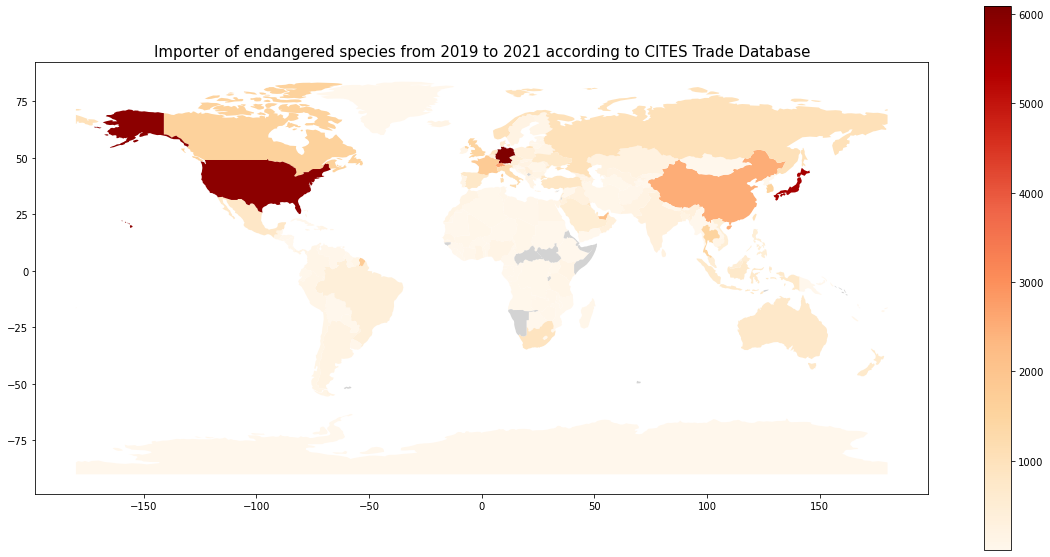

In [8]:
#Plot importer
fig, ax = plt.subplots(1, figsize = (20, 10))
importer_plot = importer_world.plot(
    column = 'Number of imported Species',
    ax=ax,
    legend = True,
    cmap='OrRd',
    missing_kwds = {"color": "lightgrey"}
    )
ax.set_title('Importer of endangered species from 2019 to 2021 according to CITES Trade Database', fontsize = 15)
plt.show()

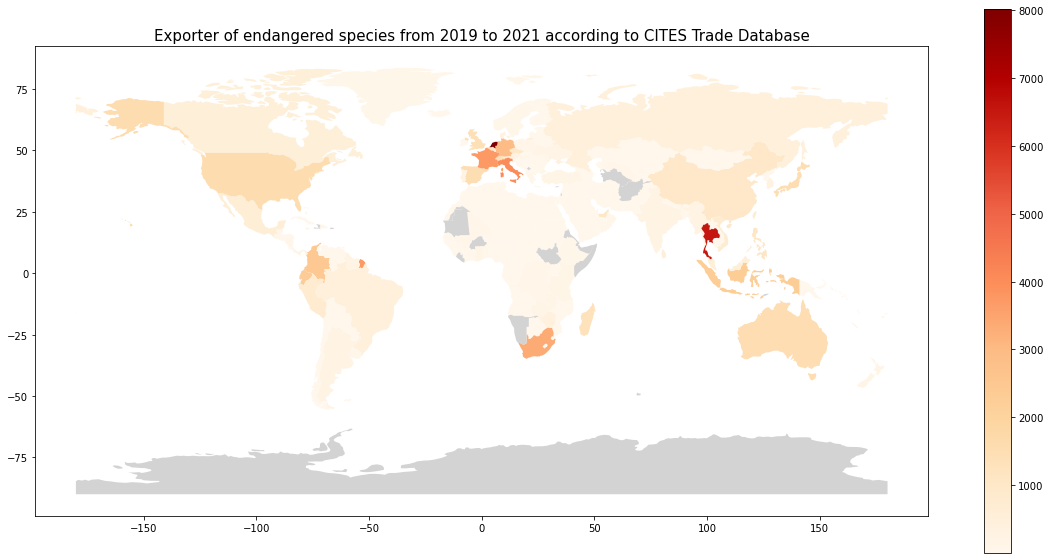

In [9]:
#Plot exporter
fig, ax = plt.subplots(1, figsize = (20, 10))
exporter_plot = exporter_world.plot(
    column = 'Number of exported Species',
    ax=ax,
    legend = True,
    cmap = "OrRd",
    missing_kwds = {"color": "lightgrey"},
    )
ax.set_title('Exporter of endangered species from 2019 to 2021 according to CITES Trade Database', fontsize = 15)
plt.show()

### Research questions one and two
The results show that the major importer countries of endangered species between 2019 and 2021 are Germany, the USA and Japan. On the other side, the major exporting countries are the Netherlands, Thailand, France, Italy and South Africa. However, it must be noted that the number of species and not the number of animals is examined. This means, that the Netherlands, for example, exports the greatest variety of species, but that is not to say that they export the highest quantity of animals. Furthermore, the origin of the traded animals is not analysed. Thereby, not all animals exported from the Netherlands must be of Dutch origin. <p>
In order to answer research question three, I know analyse the purpose of animals imported into Germany as well as animals that have been exported from the Netherlands.

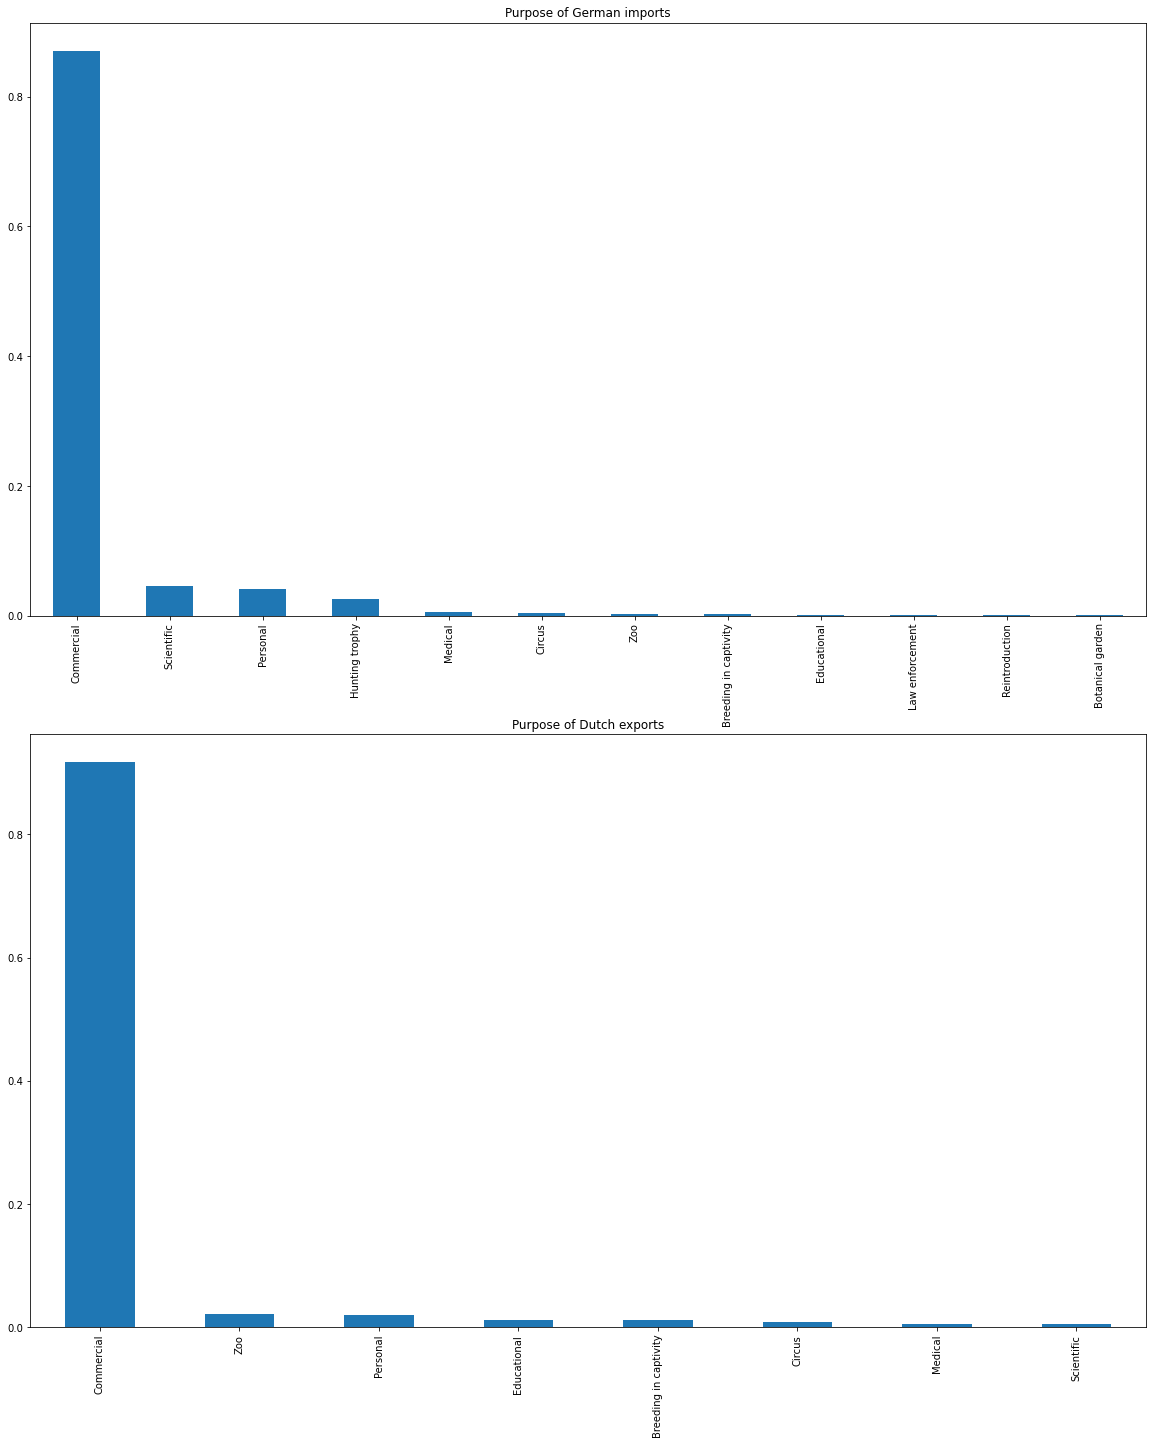

In [10]:
#Extract relative count values of purpose of imported/exported specie of Germany/the Netherlands
german_import_purpose = df[df['Importer'] == 'Germany']['Purpose'].value_counts(normalize=True)
dutch_export_purpose = df[df['Exporter'] == 'Netherlands']['Purpose'].value_counts(normalize=True)

#Create labels for barplot
labels_GER = german_import_purpose.keys()
labels_NED = dutch_export_purpose.keys()

#Create the barplot
fig, (ax1, ax2) = plt.subplots(2, figsize=[20,24])
german_import_purpose.plot.bar(title = 'Purpose of German imports', ax=ax1)
dutch_export_purpose.plot.bar(title = 'Purpose of Dutch exports', ax=ax2)
plt.show()


### Research question three
The two barplots clearly show that commercial purposes are by far the most frequent reasons for the import and export of endangered species in Germany and the Netherlands.

## Results/Discussion
Geopandas proves to be a handy tool to combine panda dataframes with spatial data. As so often in data science, the data-wrangling before non-spatial and spatial data can be merged is by far the most time consuming work. Furthermore, I realised that it is worth taking a deeper look at spatial maps provided by geopandas, since they can save you a lot of time. <p>
**Note**: My initial learning plan was focused on creating heatmaps, not cartograms. However, within my work on this section I learned that heatmaps are only used to display the distribution of point data on a spatial maps and that I actually intended to create cartograms from the beginning on.


In the final part of this notebook, I present additional visualisations that I created either for this section or the group project. <p>
Related to the work within this section, the first visualisation represents a different type of cartogram that displays the origin of traded animals.

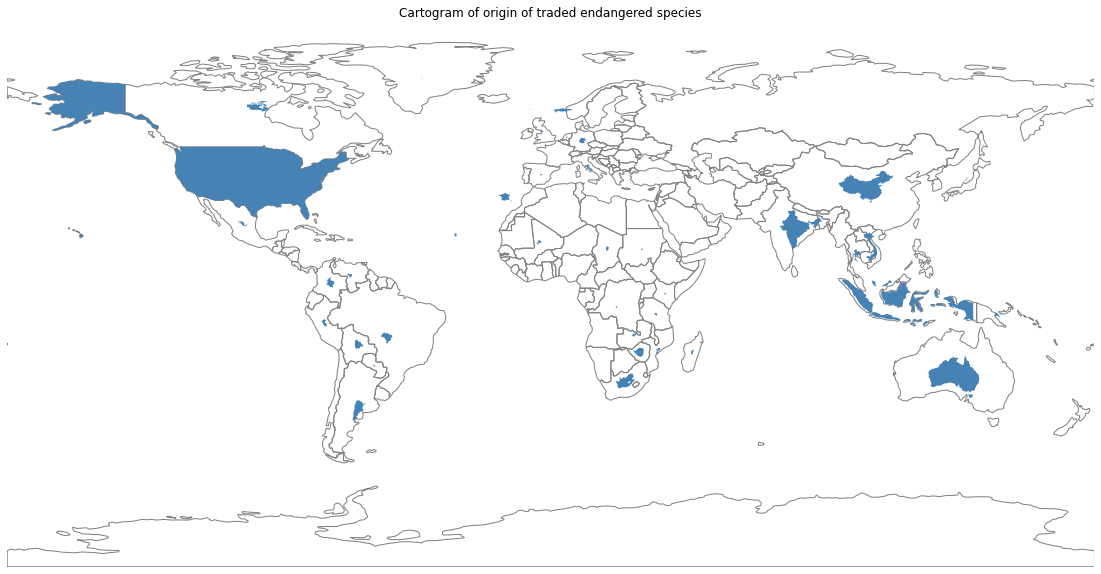

In [11]:
#Extract origin of animals from dataframe
origin = pd.DataFrame(df['Origin'].value_counts()).reset_index()
origin.rename(columns={'index': 'Country','Origin': 'Number of Species'}, inplace=True)
#Add alpha 3 label to dataframes 
origin['iso_a3'] = origin['Country'].replace(iso_a3_dict)
#Set alpha 3 label to index
origin.set_index('iso_a3', inplace = True)
#Merge origin dataframe with world map
origin_world = pd.merge(left = world[['name', 'geometry']], right=origin, left_index = True, right_index = True, how='left')
#Replace NaN-values in origin_world with zeros
origin_world['Number of Species'] = origin_world['Number of Species'].fillna(0)

#Plot cartogram
ax = gplt.cartogram(
    origin_world, scale='Number of Species', limits=(0, 1),
    edgecolor='None', figsize=(20, 10)
)
ax.set_title('Cartogram of origin of traded endangered species')
gplt.polyplot(origin_world, edgecolor='gray', ax=ax)

plt.show()

Unfortunately, this cartogram proves to be not as meaningful as the previous one. Especially because countries that feature only small numbers roam around the map. Russia, for example, can be spotted in the West of Norway. <p>
The next two visualisations stem from my contributions to the group portfolio of group SOCIAL 2.
The first graph is a radar chart, that facilitates the comparison of the different sentiments in four Dutch cities. The second graph is a collection of worldclouds that represent the most common words of each sentiment category.

In [12]:
#Load data for from group project
tweets = pd.read_csv('https://raw.githubusercontent.com/LisaPleijt/DatascienceForSmartEnvironments/main/Filtered_Tweets.csv')

#returning relative frequency of sentiment
rel_frq_AMS = tweets[tweets["city"] == "Amsterdam"]['sentiment'].value_counts(normalize = True).sort_index()
rel_frq_DEN = tweets[tweets["city"] == "Den Haag"]['sentiment'].value_counts(normalize = True).sort_index()
rel_frq_ROT = tweets[tweets["city"] == "Rotterdam"]['sentiment'].value_counts(normalize = True).sort_index()
rel_frq_UTR = tweets[tweets["city"] == "Utrecht"]['sentiment'].value_counts(normalize = True).sort_index()

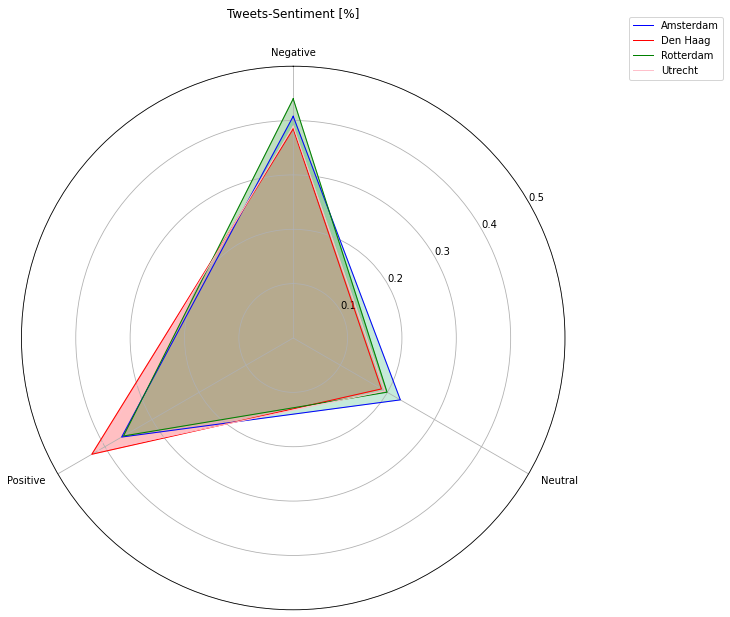

In [13]:
#RADAR CHART
#source: https://www.pythoncharts.com/matplotlib/radar-charts/

#Define function for adding cities to radar-chart
def add_to_radar(rel_frq: np.array, city: str,  color):
  values = list(rel_frq.values)
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=1, label=city)
  ax.fill(angles, values, color=color, alpha=0.25)

#Each attribute we'll plot in the radar chart.
labels = ['Negative', 'Neutral', 'Positive']

#Use Amsterdam to intialise radar-chart.
values = list(rel_frq_AMS.values)

#Number of variables we're plotting.
num_vars = len(labels)

#Split the circle into even parts and save the angles
#so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()


#The plot is a circle, so we need to "complete the loop"
#and append the start value to the end.
values += values[:1]
angles += angles[:1]

#Prepare the figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

#Draw the outline of our data.
ax.plot(angles, values, color='blue', linewidth=1, label = 'Amsterdam')
#Fill it in.
ax.fill(angles, values, color='#1aaf6c', alpha=0.25)

#Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

#Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles[0:3]), labels)

#Go through labels and adjust alignment based on where
#it is in the circle.
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

#Ensure radar goes from 0 to 100.
ax.set_ylim(0, 0.5)
#You can also set gridlines manually like this:
#ax.set_rgrids([20, 40, 60, 80, 100])

#Set position of y-labels (0-100) to be in the middle
#of the first two axes.
ax.set_rlabel_position(180 / num_vars)

#Chart title
ax.set_title('Tweets-Sentiment [%]', y=1.08)

#Add cities
add_to_radar(rel_frq_DEN, 'Den Haag', color='red')
add_to_radar(rel_frq_ROT, 'Rotterdam', color='green')
add_to_radar(rel_frq_UTR, 'Utrecht', color='pink')

#Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

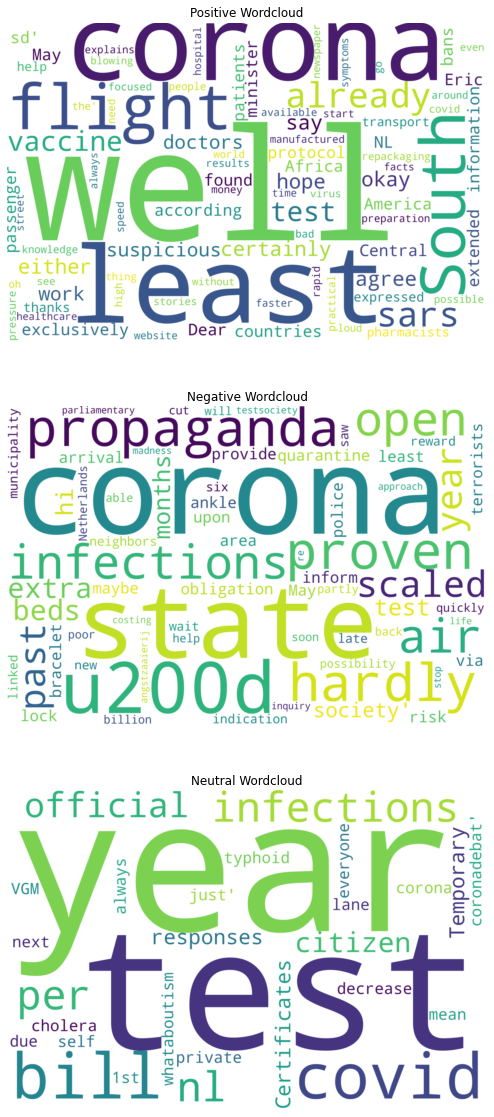

In [14]:
#WORD CLOUD
#import needed module
from wordcloud import WordCloud, STOPWORDS  

#Get text from tweets dataframe
pos_text = tweets[tweets['sentiment'] == 'positive']['text_eng'].values
neg_text = tweets[tweets['sentiment'] == 'negative']['text_eng'].values
neu_text = tweets[tweets['sentiment'] == 'neutral']['text_eng'].values

#Create positive wordcloud
pos_wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(pos_text))

#Create negative wordcloud
neg_wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(neg_text))

#Create neutral wordcloud
neu_wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(neu_text))

#Plot the three wordclouds in one plot
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (20, 20) )
ax1.imshow(pos_wordcloud, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text('Positive Wordcloud')
ax2.imshow(neg_wordcloud, interpolation = 'bilinear')
ax2.axis('off')
ax2.title.set_text('Negative Wordcloud')
ax3.imshow(neu_wordcloud, interpolation = 'bilinear')
ax3.axis('off')
ax3.title.set_text('Neutral Wordcloud')

plt.show()